# Plot Overview of CTs

Very close to the stuff for Aiko.

In [1]:
%matplotlib inline

import glob, os
import numpy as np
import pylab as pl
import xarray as xr
import datetime

In [2]:
import nawdex_analysis.io.input_lev2 as input_lev2
from tropy.standard_config import local_data_path

In [3]:
pl.rcParams['figure.figsize'] = (16.0, 12.0)
pl.rcParams['font.size'] = 16.0

## Subsampling for Speedup

In [4]:
def subsamp2d( d, nsub = 4 ):
    
    dsub = {}
    for k in d.keys():
        
        v = d[k]

        try:
            if np.ndim(v) == 2:
                vsub = v[::nsub, ::nsub]
        except:
            vsub = v
            print '%s not an 2d array?' % k
            
        dsub[k] = vsub
        
    return dsub
        

## Make a Filelist

In [5]:
# version = 'v2019-10-18'
# version = 'v2020-02-13'

version = 'v2020-06-08'


In [6]:
# old path
fdir = '%s/icon/hdcp2_atlantic_stochconv_main_experiments' % local_data_path

In [7]:
# new path
fdir = '%s/icon/stoch_exp_%s' % (local_data_path, version )

In [8]:
flist = sorted( glob.glob( '%s/nwcsaf*-hdcp2_atlantic*[!0]??.nc' % fdir) )

In [9]:
for i, fname in enumerate( flist ):
    print(i, fname )

(0, '/vols/fs1/store/senf/data/icon/stoch_exp_v2020-06-08/nwcsaf_msevi-hdcp2_atlantic-20131220.nc')
(1, '/vols/fs1/store/senf/data/icon/stoch_exp_v2020-06-08/nwcsaf_synsat-hdcp2_atlantic_detconv.nc')
(2, '/vols/fs1/store/senf/data/icon/stoch_exp_v2020-06-08/nwcsaf_synsat-hdcp2_atlantic_detconv_nolim_notundepth.nc')
(3, '/vols/fs1/store/senf/data/icon/stoch_exp_v2020-06-08/nwcsaf_synsat-hdcp2_atlantic_noconv.nc')
(4, '/vols/fs1/store/senf/data/icon/stoch_exp_v2020-06-08/nwcsaf_synsat-hdcp2_atlantic_stochconv_noconvprec_notundepth.nc')
(5, '/vols/fs1/store/senf/data/icon/stoch_exp_v2020-06-08/nwcsaf_synsat-hdcp2_atlantic_stochconv_vervel_-00.nc')


## Input BTs

In [10]:
time = datetime.datetime(2013, 12, 20, 12, 0)

dstack = {}

for fname in flist:
        basename = os.path.basename( fname )
        dstack[basename] = input_lev2.read_data_field( fname, time, 'CT')


.. open  /vols/fs1/store/senf/data/icon/nawdex//region_masks_for_msevi_nawdex.h5
.. open  /vols/fs1/store/senf/data/icon/nawdex//region_masks_for_msevi_nawdex.h5
.. open  /vols/fs1/store/senf/data/icon/nawdex//region_masks_for_msevi_nawdex.h5
.. open  /vols/fs1/store/senf/data/icon/nawdex//region_masks_for_msevi_nawdex.h5
.. open  /vols/fs1/store/senf/data/icon/nawdex//region_masks_for_msevi_nawdex.h5
.. open  /vols/fs1/store/senf/data/icon/nawdex//region_masks_for_msevi_nawdex.h5


## Reset Mask

In [11]:
o = np.ones_like( dstack[basename]['lon'] ).astype(np.bool)
for basename in dstack.keys():
    dstack[basename]['mask'] = o
    

### Sort Exp a bit

In [12]:
if version == 'v2019-10-18':
    ilist = [0, 2, 1, 5, 6 ]
elif version == 'v2020-02-13':
    ilist = [0, 2, 1, 3, 4]
elif version == 'v2020-06-08':
#    ilist = [0, 3, 2, 4]
    ilist = [0, 3, 1, 4]
   
sorted_fnames = np.array(sorted( dstack ))[ilist]

In [13]:
sorted_fnames

array(['nwcsaf_msevi-hdcp2_atlantic-20131220.nc',
       'nwcsaf_synsat-hdcp2_atlantic_noconv.nc',
       'nwcsaf_synsat-hdcp2_atlantic_detconv.nc',
       'nwcsaf_synsat-hdcp2_atlantic_stochconv_noconvprec_notundepth.nc'],
      dtype='|S63')

In [14]:
if version == 'v2020-06-08':
#     labels = ['SEVIRI', 'NOCONV', 'D-NOMFL', 'S-NOMFL']
    labels = ['SEVIRI', 'NOCONV', 'D-OPER', 'S-NOMFL']

else:
    labels = ['SEVIRI', 'NOCONV', 'D-OPER', 'S-DFLT', 'S-CPLN']

### Subsampling

In [15]:
if False: #True:
    for fname in sorted_fnames:
        dstack[fname] = subsamp2d( dstack[fname], nsub = 4 )
        

## Plot CT Matrix

In [16]:
    from tropy.plotting_tools.bmaps import Basemap
    import tropy.plotting_tools.colormaps
    import nawdex_analysis.plot.nawdex_map
    
    m = Basemap(projection='mill',
                     llcrnrlat = -10,
                     urcrnrlat = 20,
                     llcrnrlon = -65,
                     urcrnrlon = 15,
                     resolution='i')

### Color Mapping

In [17]:
def ct_colormapping( cindex ):
    
    
    # default color list provided by NWCSAF
    colorlist = ['#007800', '#000000','#fabefa','#dca0dc',
                 '#ff6400', '#ff6400', '#ffb400', '#ffb400',
                 '#f0f000', '#f0f000','#d7d796','#d7d796',
                 '#e6e6e6', '#e6e6e6', '#0050d7', '#00b4e6',
                 '#00f0f0', '#5ac8a0', '#c800c8']
    
    if cindex is None:
        return colorlist
    else:    
        color_selected = np.array( colorlist )[np.array(cindex) - 1]
    
        return color_selected

In [18]:

def ct_mapping( ct, cindex, ntypes = 20 ):
    
    if cindex is None:
        return ct
    
    # init mapping index
    mapping_index = np.zeros( ntypes ).astype( np.int ) 
    
    # overwrite mapping index with cloud types
    n = 1
    for cind in cindex:
        
        mapping_index[cind] = n
        n += 1
        
    # do the mapping
    ct_mapped = mapping_index[ ct.data.astype(np.int) ]
    
    ct_mapped = np.ma.masked_where( ct.mask, ct_mapped)
    
    return ct_mapped
    


## Plot 3 x 2 Panel

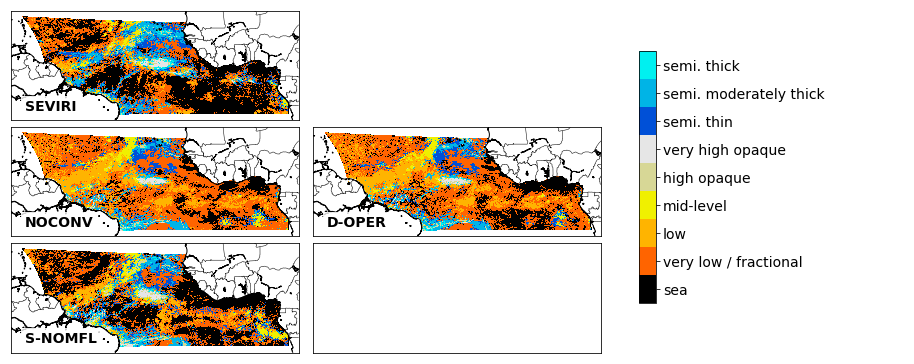

In [19]:
fig, axs_matrix = pl.subplots( nrows = 3, ncols = 3, figsize = (16, 7), sharex = True, sharey = True )
axs = axs_matrix[:,:-1].flatten()

labs = labels
color = 'gold'
cindex = [2, 6, 8, 10, 12,14, 15, 16, 17,]

colorlist = ct_colormapping( cindex )
cmap = pl.matplotlib.colors.ListedColormap( colorlist )


sorted_fnames = list ( sorted_fnames )
if not 'empty' in sorted_fnames:
    sorted_fnames.insert(1, 'empty')
    labs.insert(1, 'empty')

for i, basename in enumerate( sorted_fnames ):

    if i == 0:
        x,y = m( dstack[basename]['lon'], dstack[basename]['lat'])

    
    if basename == 'empty':
        axs[i].axis('off')
        continue

    pl.sca( axs[i] )
    m.drawcoastlines()
    m.drawcountries()

    vm = dstack[basename]['CT']
    
    # fractional --> very low
    vm[vm == 19] = 6
    vmapped = ct_mapping( vm, cindex )

    pcm = m.pcolormesh( x, y, vmapped, cmap = cmap, vmin = 1, vmax = len( colorlist ) + 1)
    m.drawlsmask(ocean_color = [0,0,0,0], land_color = 'white', zorder = 1)

    axs[i].text(4.3e5, 2e5,  labs[i], va = 'bottom', ha = 'left', fontweight = 'bold' , fontsize = 14, 
                      bbox = dict(facecolor='white', edgecolor = 'white', alpha=0.8))

#    if i >= 0:
#        break
        

pl.subplots_adjust( hspace = 0.05, wspace = 0.05, bottom = 0.2)

clabs = [np.arange(200,320,20), np.arange(200,270,10)]

for i in range(3):
    a = axs_matrix[i, -1]
    a.axis('off')
    
cax = fig.add_axes([0.67, 0.3, 0.015, 0.5])
#cax.axis('off')

if True:
        
        cbar = pl.colorbar( pcm,  cax, ticks= np.arange(9) + 1.5,)
        
        cbar.ax.set_yticklabels(['sea',  
                                 'very low / fractional', 'low', 'mid-level', 'high opaque', 'very high opaque', 
                                 'semi. thin', 'semi. moderately thick', 'semi. thick', 
                             ], fontsize = 14)
#nawdex_analysis.plot.nawdex_map.nwcsaf_product_colorbar(pcm, vname = 'CT')

pl.savefig('../pics/overview_CT_%s.jpg' % version, dpi = 300)

## Plot 3 x 2 Panel

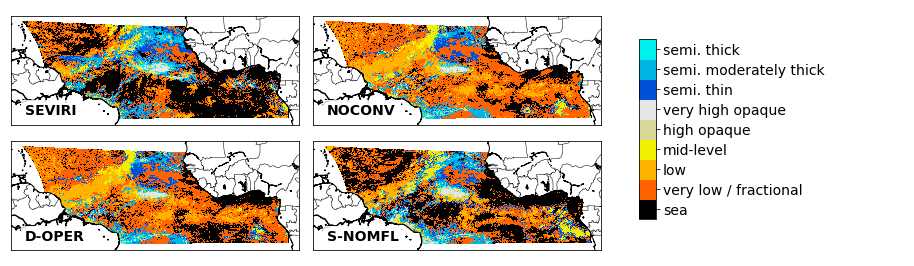

In [20]:
try:
    sorted_fnames.remove('empty')
    labs.remove('empty')
except:
    pass 

fig, axs_matrix = pl.subplots( nrows = 2, ncols = 3, figsize = (16, 5), sharex = True, sharey = True )
axs = axs_matrix[:,:-1].flatten()

labs = labels
color = 'gold'
cindex = [2, 6, 8, 10, 12,14, 15, 16, 17,]

colorlist = ct_colormapping( cindex )
cmap = pl.matplotlib.colors.ListedColormap( colorlist )

x,y = m( dstack[basename]['lon'], dstack[basename]['lat'])

sorted_fnames = list ( sorted_fnames )

for i, basename in enumerate( sorted_fnames ):
    
    if basename == 'empty':
        axs[i].axis('off')
        continue

    pl.sca( axs[i] )
    m.drawcoastlines()
    m.drawcountries()

    vm = dstack[basename]['CT']
    
    # fractional --> very low
    vm[vm == 19] = 6
    vmapped = ct_mapping( vm, cindex )

    pcm = m.pcolormesh( x, y, vmapped, cmap = cmap, vmin = 1, vmax = len( colorlist ) + 1)
    m.drawlsmask(ocean_color = [0,0,0,0], land_color = 'white', zorder = 1)

    axs[i].text(4.3e5, 2e5,  labs[i], va = 'bottom', ha = 'left', fontweight = 'bold' , fontsize = 14, 
                      bbox = dict(facecolor='white', edgecolor = 'white', alpha=0.8))

#    if i >= 0:
#        break
        

pl.subplots_adjust( hspace = 0.05, wspace = 0.05, bottom = 0.2)

clabs = [np.arange(200,320,20), np.arange(200,270,10)]

for i in range(2):
    a = axs_matrix[i, -1]
    a.axis('off')
    
cax = fig.add_axes([0.67, 0.3, 0.015, 0.5])
#cax.axis('off')

if True:
        
        cbar = pl.colorbar( pcm,  cax, ticks= np.arange(9) + 1.5,)
        
        cbar.ax.set_yticklabels(['sea',  
                                 'very low / fractional', 'low', 'mid-level', 'high opaque', 'very high opaque', 
                                 'semi. thin', 'semi. moderately thick', 'semi. thick', 
                             ], fontsize = 14)
#nawdex_analysis.plot.nawdex_map.nwcsaf_product_colorbar(pcm, vname = 'CT')

pl.savefig('../pics/overview_CT_%s.jpg' % version, dpi = 300)